<a href="https://colab.research.google.com/github/Kell1000/Big_data/blob/main/TP_01_Pyspark_Colab/TP_PySpark_BigData_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP PySpark avec GPU T4 - Analyse Big Data E-Commerce

Maîtriser PySpark sur Google Colab avec accélération GPU pour analyser des données e-commerce à grande échelle

---

## Table des matières
1. Configuration de l'environnement
2. Chargement et exploration des données
3. Nettoyage et transformation
4. Analyses avancées
5. Machine Learning
6. Optimisation des performances
7. Dashboard et visualisations

---
## PARTIE 1: Configuration de l'environnement

In [1]:
# Installer PySpark et dépendances
!pip install pyspark kaggle findspark -q

print("Installation terminée!")

Installation terminée!


In [2]:
import torch

print("GPU available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


GPU available: True
GPU name: Tesla T4


In [3]:
# Vérifier le GPU T4 disponible
!nvidia-smi

Wed Feb 18 22:40:39 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             10W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
# 1. Installation de Java
!apt-get install -y openjdk-11-jdk -q

# 2. Téléchargement de Spark (Lien mis à jour vers les archives officielles)
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz

# 3. Vérification et Extraction
import os
if os.path.exists("spark-3.5.0-bin-hadoop3.tgz"):
    print("Téléchargement réussi. Extraction en cours...")
    !tar xf spark-3.5.0-bin-hadoop3.tgz
    !mv spark-3.5.0-bin-hadoop3 /usr/local/spark
    print("Spark est installé dans /usr/local/spark")
else:
    print("Erreur : Le fichier n'a pas été téléchargé. Vérifiez votre connexion internet.")


Reading package lists...
Building dependency tree...
Reading state information...
openjdk-11-jdk is already the newest version (11.0.30+7-1ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Téléchargement réussi. Extraction en cours...
Spark est installé dans /usr/local/spark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 25.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 1.0.2 requires pyspark[connect]~=4.0.0, but you have pyspark 3.5.0 which is incompatible.
ERROR: Could not find a version that satisfies the requirement rapids-4-spark-24.12.0 (from versions: none)
ERROR: No matching distribution found for rapids-4-spa

In [7]:

!pip install -q pyspark==3.5.0 findspark nvidia-pyindex

# 3. Téléchargement du connecteur GPU RAPIDS (Le fichier JAR est nécessaire)
# Nous téléchargeons le JAR directement pour que Spark puisse l'utiliser
!wget -q https://repo1.maven.org/maven2/com/nvidia/rapids-4-spark_2.12/24.12.0/rapids-4-spark_2.12-24.12.0.jar -P /usr/local/spark/jars/

In [8]:
# 4. Configuration des variables d'environnement
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/usr/local/spark"

import findspark
findspark.init()

In [16]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Spark_GPU_Colab") \
    .config("spark.plugins", "com.nvidia.spark.SQLPlugin") \
    .config("spark.rapids.sql.enabled", "true") \
    .config("spark.executor.resource.gpu.amount", "1") \
    .config("spark.task.resource.gpu.amount", "1") \
    .config("spark.sql.adaptive.enabled", "false") \
    .getOrCreate()

print("Système Spark avec GPU prêt !")
# Test de vérification
# spark.range(10).selectExpr("id * 2").show()

Système Spark avec GPU prêt !


In [17]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Spark_GPU_RAPIDS") \
    .config("spark.plugins", "com.nvidia.spark.SQLPlugin") \
    .config("spark.rapids.sql.enabled", "true") \
    .config("spark.executor.resource.gpu.amount", "1") \
    .config("spark.task.resource.gpu.amount", "0.25") \
    .config("spark.jars.packages", "com.nvidia:rapids-4-spark_2.12:24.12.0") \
    .getOrCreate()

print("Session Spark GPU démarrée")

Session Spark GPU démarrée


In [18]:
# Imports
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("Imports réussis!")

Imports réussis!


### Téléchargement des données depuis Kaggle

In [19]:
# Uploader votre fichier kaggle.json
from google.colab import files

print("Veuillez uploader votre fichier kaggle.json")
uploaded = files.upload()

# Configurer Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle configuré!")

Veuillez uploader votre fichier kaggle.json


Saving kaggle.json to kaggle.json
Kaggle configuré!


In [20]:
# Télécharger le dataset
!kaggle datasets download -d mkechinov/ecommerce-behavior-data-from-multi-category-store
!unzip -q ecommerce-behavior-data-from-multi-category-store.zip
!ls -lh *.csv

print("Dataset téléchargé!")

Dataset URL: https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store
License(s): copyright-authors
 99% 4.24G/4.29G [00:32<00:01, 39.6MB/s]
100% 4.29G/4.29G [00:32<00:00, 141MB/s] 
-rw-r--r-- 1 root root 8.4G Dec  9  2019 2019-Nov.csv
-rw-r--r-- 1 root root 5.3G Dec  9  2019 2019-Oct.csv
Dataset téléchargé!


---
## PARTIE 2: Chargement et exploration des données

In [ ]:
# Définir le schéma pour optimiser le chargement
schema = StructType([
    StructField("event_time", TimestampType(), True),
    StructField("event_type", StringType(), True),
    StructField("product_id", IntegerType(), True),
    StructField("category_id", LongType(), True),
    StructField("category_code", StringType(), True),
    StructField("brand", StringType(), True),
    StructField("price", FloatType(), True),
    StructField("user_id", IntegerType(), True),
    StructField("user_session", StringType(), True)
])

# Charger les données
df = spark.read.csv(
    "2019-Oct.csv",
    header=True,
    schema=schema,
    timestampFormat="yyyy-MM-dd HH:mm:ss z"
)

# Cacher en mémoire
df.cache()

print(f"Données chargées: {df.count():,} lignes")
print(f"Nombre de partitions: {df.rdd.getNumPartitions()}")

In [ ]:
# Explorer le schéma
df.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: float (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)



In [ ]:
# Aperçu des données
df.show(10, truncate=False)

+-------------------+----------+----------+-------------------+-----------------------------------+--------+-------+---------+------------------------------------+
|event_time         |event_type|product_id|category_id        |category_code                      |brand   |price  |user_id  |user_session                        |
+-------------------+----------+----------+-------------------+-----------------------------------+--------+-------+---------+------------------------------------+
|2019-10-01 00:00:00|view      |44600062  |2103807459595387724|NULL                               |shiseido|35.79  |541312140|72d76fde-8bb3-4e00-8c23-a032dfed738c|
|2019-10-01 00:00:00|view      |3900821   |2053013552326770905|appliances.environment.water_heater|aqua    |33.2   |554748717|9333dfbd-b87a-4708-9857-6336556b0fcc|
|2019-10-01 00:00:01|view      |17200506  |2053013559792632471|furniture.living_room.sofa         |NULL    |543.1  |519107250|566511c2-e2e3-422b-b695-cf8e6e792ca8|
|2019-10-01 00:0

In [ ]:
# Statistiques descriptives
df.describe().show()

+-------+----------+--------------------+--------------------+-------------------+--------+-----------------+-------------------+--------------------+
|summary|event_type|          product_id|         category_id|      category_code|   brand|            price|            user_id|        user_session|
+-------+----------+--------------------+--------------------+-------------------+--------+-----------------+-------------------+--------------------+
|  count|  42448764|            42448764|            42448764|           28933155|36335756|         42448764|           42448764|            42448762|
|   mean|      NULL|1.0549932375842676E7|2.057404237936260...|               NULL|     NaN|290.3236605861753|5.335371475081686E8|                NULL|
| stddev|      NULL|1.1881906970608136E7|1.843926466140411...|               NULL|     NaN| 358.269155825444|1.852373817465431E7|                NULL|
|    min|      cart|             1000978| 2053013552226107603|    accessories.bag|  a-case|   

In [ ]:
# Vérifier les valeurs manquantes
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code|  brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|         0|         0|         0|          0|     13515609|6113008|    0|      0|           2|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+



### EXERCICE 1: Analyse exploratoire

 Réaliser une exploration complète des données

1. Compter le nombre d'événements par type (view, cart, purchase)
2. Trouver les 10 produits les plus vus
3. Calculer le prix moyen par catégorie
4. Identifier les heures de pic d'activité

In [ ]:
# TON CODE ICI - EXERCICE 1




=== Événements par type ===
+----------+--------+
|event_type|   count|
+----------+--------+
|      view|40779399|
|      cart|  926516|
|  purchase|  742849|
+----------+--------+


=== Top 10 produits les plus vus ===
+----------+-------+---------------------------+----------+
|product_id|brand  |category_code              |view_count|
+----------+-------+---------------------------+----------+
|1004856   |samsung|electronics.smartphone     |419287    |
|1004767   |samsung|electronics.smartphone     |378777    |
|1005115   |apple  |electronics.smartphone     |327715    |
|1004249   |apple  |electronics.smartphone     |207422    |
|1004833   |samsung|electronics.smartphone     |203018    |
|1005105   |apple  |electronics.smartphone     |197930    |
|1004870   |samsung|electronics.smartphone     |190435    |
|1002544   |apple  |electronics.smartphone     |179249    |
|4804056   |apple  |electronics.audio.headphone|179092    |
|5100816   |xiaomi |NULL                       |164608    |

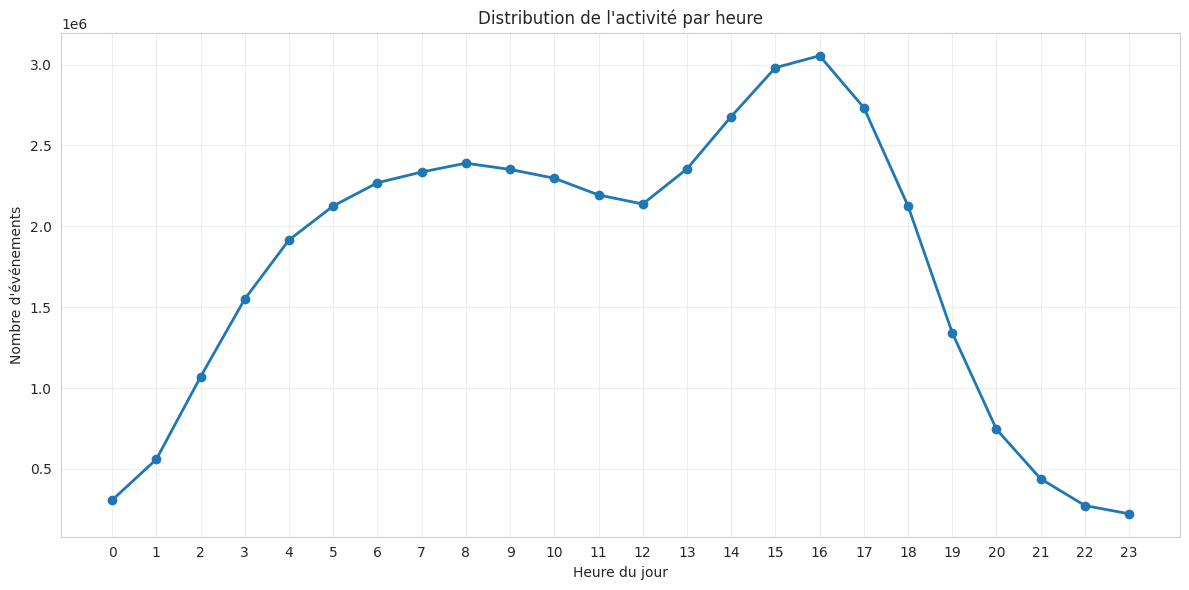

In [ ]:
# Visualisation


---
## PARTIE 3: Nettoyage et transformation des données

In [ ]:
# Nettoyage des données
df_clean = df.filter(
    (col("product_id").isNotNull()) &
    (col("user_id").isNotNull()) &
    (col("price") > 0)
)

# Extraire les features temporelles
df_clean = df_clean.withColumn("hour", hour("event_time")) \
                   .withColumn("day_of_week", dayofweek("event_time")) \
                   .withColumn("day", dayofmonth("event_time")) \
                   .withColumn("month", month("event_time"))

# Créer une catégorie principale
df_clean = df_clean.withColumn(
    "main_category",
    split(col("category_code"), "\\.").getItem(0)
)

print(f"Données nettoyées: {df_clean.count():,} lignes")
df_clean.show(5)

Données nettoyées: 42,380,091 lignes
+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+----+-----------+---+-----+-------------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|hour|day_of_week|day|month|main_category|
+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+----+-----------+---+-----+-------------+
|2019-10-01 00:00:00|      view|  44600062|2103807459595387724|                NULL|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|   0|          3|  1|   10|         NULL|
|2019-10-01 00:00:00|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|   33.2|554748717|9333dfbd-b87a-470...|   0|          3|  1|   10|   appliances|
|2019-10-01 00:00:01|      view|  17200506|2053013559792632471|furniture.living_...|    NULL|

In [ ]:
# Feature Engineering - Métriques utilisateur
user_metrics = df_clean.groupBy("user_id").agg(
    count("*").alias("total_events"),
    count_distinct("product_id").alias("unique_products_viewed"),
    sum(when(col("event_type") == "purchase", 1).otherwise(0)).alias("purchases"),
    sum(when(col("event_type") == "cart", 1).otherwise(0)).alias("cart_additions"),
    avg("price").alias("avg_price_interest"),
    max("price").alias("max_price_interest")
)

# Taux de conversion
user_metrics = user_metrics.withColumn(
    "conversion_rate",
    (col("purchases") / col("total_events")) * 100
)

user_metrics.show(10)

+---------+------------+----------------------+---------+--------------+------------------+------------------+------------------+
|  user_id|total_events|unique_products_viewed|purchases|cart_additions|avg_price_interest|max_price_interest|   conversion_rate|
+---------+------------+----------------------+---------+--------------+------------------+------------------+------------------+
|555474035|           4|                     4|        0|             0|139.17249965667725|             344.9|               0.0|
|543393778|          55|                    35|        0|             4|438.56909290660514|           1335.79|               0.0|
|518661558|          42|                    33|        0|             0| 73.41809531620571|            259.98|               0.0|
|555529451|           9|                     8|        0|             0| 433.8300031026204|            975.57|               0.0|
|522737752|          36|                    10|        2|             0| 351.5500011444092

### EXERCICE 2: Transformation avancée
Créer une table d'analyse produit complète

1. Créer une table avec pour chaque produit:
   - Nombre de vues
   - Nombre d'ajouts au panier
   - Nombre d'achats
   - Taux de conversion
   - Marque et catégorie

In [ ]:
# TON CODE ICI - EXERCICE 2



=== Analyse complète des produits ===
+----------+-------+---------------------------+-----------+----------+---------------+------------------+------------+------------------+------------------+---------------------+-----------------+
|product_id|brand  |category_code              |total_views|total_cart|total_purchases|avg_price         |unique_users|conversion_rate   |cart_rate         |cart_to_purchase_rate|performance_class|
+----------+-------+---------------------------+-----------+----------+---------------+------------------+------------+------------------+------------------+---------------------+-----------------+
|1004856   |samsung|electronics.smartphone     |419287     |52123     |28944          |131.23644181092882|197878      |6.903147486089481 |12.431341777827598|55.53018820866028    |Star             |
|1004767   |samsung|electronics.smartphone     |378777     |37649     |21806          |248.9845577031703 |175611      |5.7569493395850335|9.939621465928502 |57.9192010411

In [ ]:
from pyspark.sql.functions import col, when, count

# 1. Suppression des doublons et gestion des valeurs nulles
df_clean = df.dropDuplicates().dropna(subset=["user_id", "product_id"])

# 2. Conversion des types
df_clean = df_clean.withColumn("price", col("price").cast("float")) \
                   .withColumn("event_time", col("event_time").cast("timestamp"))

# 3. Création de nouvelles features (ex: heure de l'achat)
from pyspark.sql.functions import hour
df_clean = df_clean.withColumn("hour", hour(col("event_time")))

---
## PARTIE 4: Analyses avancées

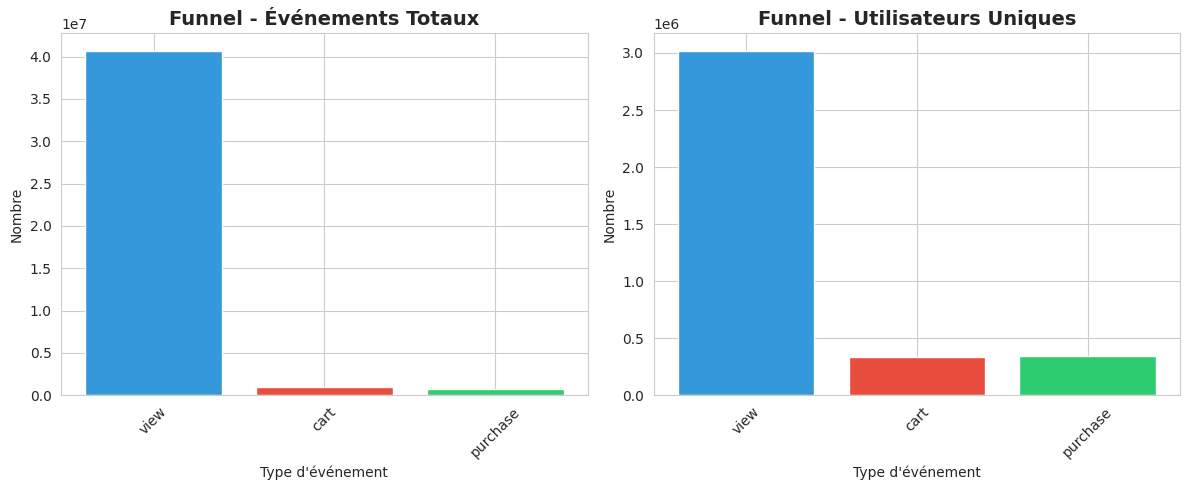

In [ ]:
# Funnel de conversion
funnel = df_clean.groupBy("event_type").agg(
    count("*").alias("count"),
    count_distinct("user_id").alias("unique_users")
).orderBy(col("count").desc())

funnel_pd = funnel.toPandas()

# Visualisation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(funnel_pd['event_type'], funnel_pd['count'], color=['#3498db', '#e74c3c', '#2ecc71'])
plt.title('Funnel - Événements Totaux', fontsize=14, fontweight='bold')
plt.xlabel('Type d\'événement')
plt.ylabel('Nombre')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(funnel_pd['event_type'], funnel_pd['unique_users'], color=['#3498db', '#e74c3c', '#2ecc71'])
plt.title('Funnel - Utilisateurs Uniques', fontsize=14, fontweight='bold')
plt.xlabel('Type d\'événement')
plt.ylabel('Nombre')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Analyse RFM (Recency, Frequency, Monetary)
max_date = df_clean.agg(max("event_time")).collect()[0][0]

rfm = df_clean.filter(col("event_type") == "purchase") \
    .groupBy("user_id").agg(
        datediff(lit(max_date), max("event_time")).alias("recency"),
        count("*").alias("frequency"),
        sum("price").alias("monetary")
    )

# Segmentation
rfm = rfm.withColumn(
    "rfm_segment",
    when((col("recency") < 7) & (col("frequency") > 5) & (col("monetary") > 1000), "Champion")
    .when((col("recency") < 14) & (col("frequency") > 3), "Loyal")
    .when((col("recency") < 30) & (col("frequency") > 1), "Potential")
    .when(col("recency") >= 30, "At Risk")
    .otherwise("New")
)

rfm.groupBy("rfm_segment").count().orderBy(col("count").desc()).show()

+-----------+------+
|rfm_segment| count|
+-----------+------+
|        New|209538|
|  Potential|101078|
|      Loyal| 20147|
|   Champion|  9038|
|    At Risk|  7317|
+-----------+------+



### EXERCICE 3: Analyse des tendances temporelles
Analyser les patterns temporels de ventes

1. Ventes totales par jour
2. Ventes moyennes par heure de la journée
3. Produits les plus vendus par jour de la semaine
4. Créer un graphique de tendance des ventes

=== Ventes totales par jour ===
+----------+-----------------+-----------------+-------------+
|      date|      total_sales|transaction_count|unique_buyers|
+----------+-----------------+-----------------+-------------+
|2019-10-01|6275964.013664722|            19307|        14064|
|2019-10-02|6213628.530254185|            19469|        13894|
|2019-10-03|6233782.976109505|            19255|        13722|
|2019-10-04|8623684.485102654|            27041|        19214|
|2019-10-05|7341596.922312498|            23494|        16734|
|2019-10-06|6737660.791445732|            22171|        16096|
|2019-10-07|6348189.059839129|            21378|        15438|
|2019-10-08|6819832.297592342|            23072|        16590|
|2019-10-09|6855511.141445696|            22748|        16417|
|2019-10-10|6665600.838861167|            21993|        15959|
|2019-10-11|7716208.542229176|            26224|        18818|
|2019-10-12|7307691.562465131|            25373|        18374|
|2019-10-13|8457606.489

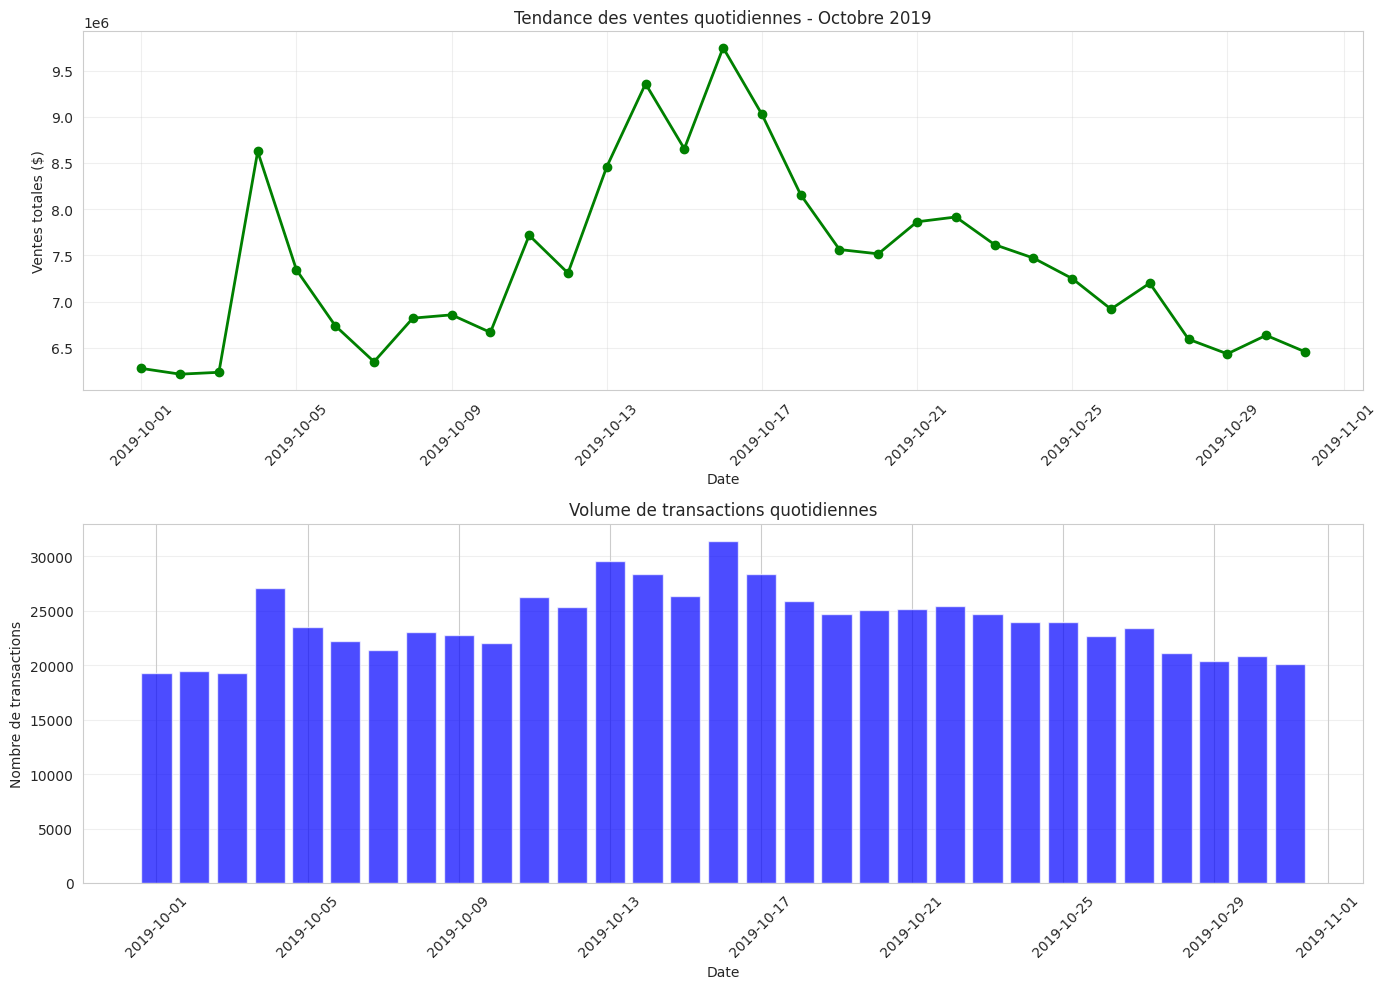

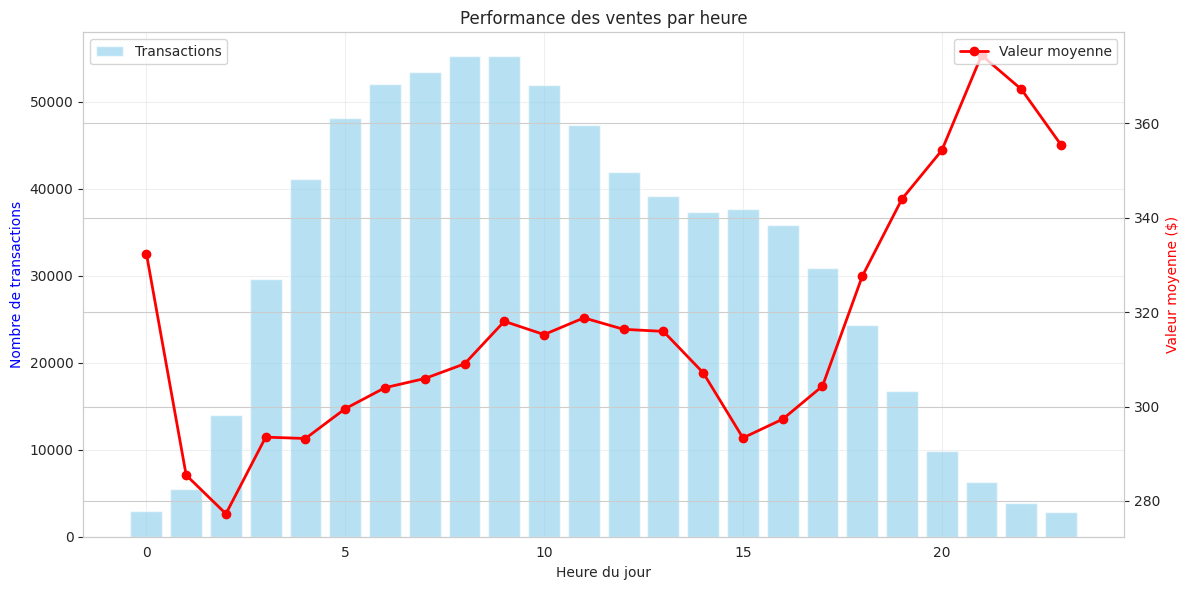

In [ ]:
# TON CODE ICI - EXERCICE 3



---
## PARTIE 5: Machine Learning avec PySpark ML

### 5.1 - Segmentation client avec K-Means

In [ ]:
# Préparer les features
feature_cols = ["total_events", "unique_products_viewed",
                "purchases", "cart_additions", "avg_price_interest"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
user_metrics_assembled = assembler.transform(user_metrics)

# Normaliser
scaler = StandardScaler(inputCol="features_raw", outputCol="features")
scaler_model = scaler.fit(user_metrics_assembled)
user_metrics_scaled = scaler_model.transform(user_metrics_assembled)

print("Features préparées!")

In [ ]:
# Méthode du coude pour trouver k optimal
costs = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(k=k, seed=42, featuresCol="features")
    model = kmeans.fit(user_metrics_scaled)
    costs.append(model.summary.trainingCost)
    print(f"k={k}: WSSSE = {model.summary.trainingCost:.2f}")

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(K_range, costs, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Nombre de clusters (k)', fontsize=12)
plt.ylabel('Coût (WSSSE)', fontsize=12)
plt.title('Méthode du coude pour K-Means', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Entraîner avec k=4 (ou ton choix)
kmeans = KMeans(k=4, seed=42, featuresCol="features", predictionCol="cluster")
kmeans_model = kmeans.fit(user_metrics_scaled)

# Prédire
clustered_users = kmeans_model.transform(user_metrics_scaled)

# Analyser
cluster_summary = clustered_users.groupBy("cluster").agg(
    count("*").alias("count"),
    avg("total_events").alias("avg_events"),
    avg("purchases").alias("avg_purchases"),
    avg("conversion_rate").alias("avg_conversion_rate")
)

cluster_summary.show()

### 5.2 - Système de recommandation avec ALS

In [ ]:
# Préparer les données pour ALS
purchases = df_clean.filter(col("event_type") == "purchase") \
    .select("user_id", "product_id", "price")

# Créer un rating implicite
purchases = purchases.withColumn("rating",
    when(col("price") > 1000, 5.0)
    .when(col("price") > 500, 4.0)
    .when(col("price") > 200, 3.0)
    .when(col("price") > 50, 2.0)
    .otherwise(1.0)
)

# Split
train, test = purchases.randomSplit([0.8, 0.2], seed=42)

print(f"Train: {train.count():,} | Test: {test.count():,}")

In [ ]:
# Configurer ALS
als = ALS(
    maxIter=10,
    regParam=0.1,
    userCol="user_id",
    itemCol="product_id",
    ratingCol="rating",
    coldStartStrategy="drop",
    nonnegative=True
)

# Entraîner
print("Entraînement du modèle ALS...")
als_model = als.fit(train)
print("Modèle entraîné!")

In [ ]:
# Prédictions
predictions = als_model.transform(test)

# Évaluation
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print(f"RMSE = {rmse:.4f}")

In [ ]:
# Générer des recommandations
user_recs = als_model.recommendForAllUsers(10)
user_recs.show(5, truncate=False)

### EXERCICE 4: Machine Learning avancé
 Améliorer le système de recommandation


1. Créer un rating composite (vues + panier + achats)
2. Optimiser les hyperparamètres (regParam, rank)
3. Générer des recommandations pour un utilisateur spécifique
4. Évaluer avec différentes métriques (RMSE, MAE, R²)

In [ ]:
# TON CODE ICI - EXERCICE 4





---
## PARTIE 6: Optimisation des performances

In [ ]:
import time

def benchmark_query(df, query_name, query_func):
    """Fonction pour mesurer les performances"""
    start = time.time()
    result = query_func(df)
    result.count()
    end = time.time()
    duration = end - start
    print(f"{query_name:40s}: {duration:6.2f}s")
    return duration

# Requêtes de test
def heavy_aggregation(df):
    return df.groupBy("user_id", "product_id", "event_type") \
        .agg(
            count("*").alias("count"),
            sum("price").alias("total_price"),
            avg("price").alias("avg_price")
        )

print("=" * 60)
print(" " * 15 + "BENCHMARK DE PERFORMANCE")
print("=" * 60)

benchmark_query(df_clean, "Agrégation lourde", heavy_aggregation)

In [ ]:
# Avec repartitionnement
df_optimized = df_clean.repartition(200, "user_id")

print("\nAVEC REPARTITIONNEMENT:")
benchmark_query(df_optimized, "Agrégation lourde (optimisée)", heavy_aggregation)

### EXERCICE 5: Optimisation avancée

 Optimiser les performances de tes requêtes


1. Identifier tes requêtes les plus lentes
2. Appliquer le caching stratégique
3. Tester différents nombres de partitions
4. Comparer les performances avant/après

In [ ]:
# TON CODE ICI - EXERCICE 5





---
## PARTIE 7: Dashboard et visualisations finales

In [ ]:
# Métriques clés
total_revenue = df_clean.filter(col("event_type") == "purchase") \
    .agg(sum("price")).collect()[0][0]

total_orders = df_clean.filter(col("event_type") == "purchase").count()

unique_customers = df_clean.filter(col("event_type") == "purchase") \
    .select("user_id").distinct().count()

aov = total_revenue / total_orders

print("=" * 80)
print(" " * 25 + "TABLEAU DE BORD E-COMMERCE")
print("=" * 80)
print(f"\n Revenue Total: ${total_revenue:,.2f}")
print(f"Nombre de commandes: {total_orders:,}")
print(f"Clients uniques: {unique_customers:,}")
print(f"Panier moyen (AOV): ${aov:.2f}")
print("\n" + "=" * 80)

In [ ]:
# Top produits par revenue
top_products = df_clean.filter(col("event_type") == "purchase") \
    .groupBy("product_id", "brand", "main_category") \
    .agg(
        sum("price").alias("total_revenue"),
        count("*").alias("sales_count")
    ) \
    .orderBy(col("total_revenue").desc()) \
    .limit(10) \
    .toPandas()

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Top produits
axes[0, 0].barh(range(len(top_products)), top_products['total_revenue'])
axes[0, 0].set_yticks(range(len(top_products)))
axes[0, 0].set_yticklabels(top_products['brand'].fillna('Unknown'))
axes[0, 0].set_xlabel('Revenue ($)')
axes[0, 0].set_title('Top 10 Produits par Revenue', fontsize=14, fontweight='bold')
axes[0, 0].invert_yaxis()

# Distribution par catégorie
category_sales = df_clean.filter(col("event_type") == "purchase") \
    .groupBy("main_category") \
    .agg(sum("price").alias("revenue")) \
    .toPandas()

axes[0, 1].pie(category_sales['revenue'],
               labels=category_sales['main_category'],
               autopct='%1.1f%%')
axes[0, 1].set_title('Distribution Revenue par Catégorie', fontsize=14, fontweight='bold')

# Activité horaire
hourly = df_clean.groupBy("hour", "event_type").count().toPandas()
hourly_pivot = hourly.pivot(index='hour', columns='event_type', values='count').fillna(0)
hourly_pivot.plot(kind='line', ax=axes[1, 0], marker='o')
axes[1, 0].set_xlabel('Heure')
axes[1, 0].set_ylabel('Nombre d\'événements')
axes[1, 0].set_title('Activité par Heure', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Transactions
category_trans = df_clean.filter(col("event_type") == "purchase") \
    .groupBy("main_category") \
    .count() \
    .toPandas()

axes[1, 1].bar(category_trans['main_category'], category_trans['count'])
axes[1, 1].set_xlabel('Catégorie')
axes[1, 1].set_ylabel('Transactions')
axes[1, 1].set_title('Transactions par Catégorie', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### EXERCICE 6: Dashboard complet

Créer un dashboard analytique complet

1. KPIs principaux (revenue, conversion, AOV)
2. Analyse de cohorte (comportement dans le temps)
3. Analyse de panier (produits souvent achetés ensemble)
4. Prédiction de churn (RFM)
5. Recommandations personnalisées pour 5 utilisateurs

In [ ]:
# TON CODE ICI - EXERCICE 6 (Projet Final)





---
## Conclusion et nettoyage